In [1]:
#Control time packages
import time
import os

os.environ["OMP_NUM_THREADS"] = "1"


import numpy as np
import matplotlib.pyplot as plt
from plotbin.plot_velfield import plot_velfield
from My_Jampy import JAM                          #My class for jampy


from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

from schwimmbad import MPIPool

boundary = {"ml0": [0.5, 15], "delta": [0.1, 2], "lower": [0, 1],  
                "qinc": [0.051, 0.468808], "beta": [-3, 3],
                "log_mbh": [7, 11]}

def gaussian_ml(sigma, delta, ml0=1.0, lower=0.4):
    """
    Create a M*L gradient
    Input:
    -----------
        sigma: Gaussian sigma                           [arcsec]
        delta: Gradient value
        ml0: Central stellar mass to light ratio        [M_sun/L_sun]    
        lower: the ratio between the central and the outer most M/L
    Output:
    ----------
        ML: gaussian mass to light ratio. One component per gaussian in surf_lum.
    """

    sigma = np.atleast_1d(sigma)
    sigma = sigma - sigma[0]
    ML = ml0 * (lower + (1-lower)*np.exp(-0.5 * (sigma * delta)**2))
    
    return ML

In [3]:
class Model(object):
    def __init__(self, Jam_model):
        self.Jam_model = Jam_model

    def prior_transform(self, theta):
        ml0, delta, lower, qinc, beta, log_mbh = theta
        parsDic = {"ml0":ml0, "delta": delta, "lower": lower, "qinc":qinc, 
                "beta":beta, "log_mbh":log_mbh}
        for key in parsDic:
            parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
        
        return np.array(list(parsDic.values()))

    def log_likelihood(self, theta):
        ml0, delta, lower, qinc, beta, log_mbh = theta = theta  
        # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
        qmin = np.min(self.Jam_model.qobs_lum)
        inc_model = np.degrees(np.arctan(np.sqrt((1 - qmin**2)/(qmin**2 -qinc**2))))
        

        beta_model  = np.ones_like(self.Jam_model.qobs_lum)*beta
        ml_model    = gaussian_ml(sigma=self.Jam_model.sigma_lum, ml0=ml0, delta=delta, lower=lower)
        mbh_model   = 10**log_mbh
        
        self.Jam_model.upt(inc=inc_model, ml=ml_model, beta=beta_model, mbh=mbh_model)
        
        rmsModel, ml, chi2, chi2T = self.Jam_model.run(quiet=False, plot=True)
        
        
        return -0.5 * chi2T

    def __call__(self, pars):
        return self.log_likelihood(pars)

def resume_dlogz(sampler):
        results = sampler.results
        logz_remain = np.max(sampler.live_logl) + results.logvol[-1]
        delta_logz = np.logaddexp(results.logz[-1], logz_remain) - results.logz[-1]
        
        return delta_logz

In [4]:
# Reading Data
x, y, vrms, erms              = np.loadtxt("Input/Vrms_map_rot.txt", unpack=True)           #vrms data
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)              #MGE decomposition
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True)         #PSF

# Defing some inputs
z_l     = 0.299                                                         #Redshift
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, -0.15)                                 #anisotropy [ad]
inc     = 65                                                            #inclination [deg]
ml      = gaussian_ml(sigma_lum, delta=0.5, ml0=7.0, lower=0.4)         #mass to light ratio
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                        (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)   #Deprojected axial ratio for inclination

pixsize = 0.2    #MUSE pixel size

# Now we start our Jampy class
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms, normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)

model = Model(Jam_model=Jam_model)


Testing Inputs...
jam_axi_rms elapsed time sec: 0.42
inc=65.0 beta_z=-0.15 M/L=1 BH=1.00e+09 chi2/DOF=23.3
Total mass MGE: 5.017e+11
Likelihood Value: -3375.660593565426


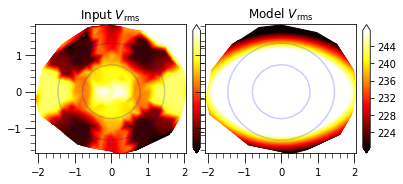

In [6]:
print("Testing Inputs...")
#ML0, delta, lower, qinc, beta, log_mbh
p0 = np.array([7.0, 0.5, 0.4, qinc, beta[0], np.log10(mbh)])
print("Likelihood Value:", model(p0))

In [103]:
import pickle
with open(f'final_jam_gaussianML_noDM.pickle','rb') as f:
    sample_load = pickle.load(f)

In [104]:
results = sample_load.results
results.summary()

Summary
nlive: 150
niter: 3453
ncall: 15438
eff(%): 23.339
logz: -977.712 +/-  0.488


In [105]:
sample_load.results.keys()

dict_keys(['nlive', 'niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'])

In [106]:
resume_dlogz(sample_load)

0.0006565400543649957

In [107]:
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

/home/carlos/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


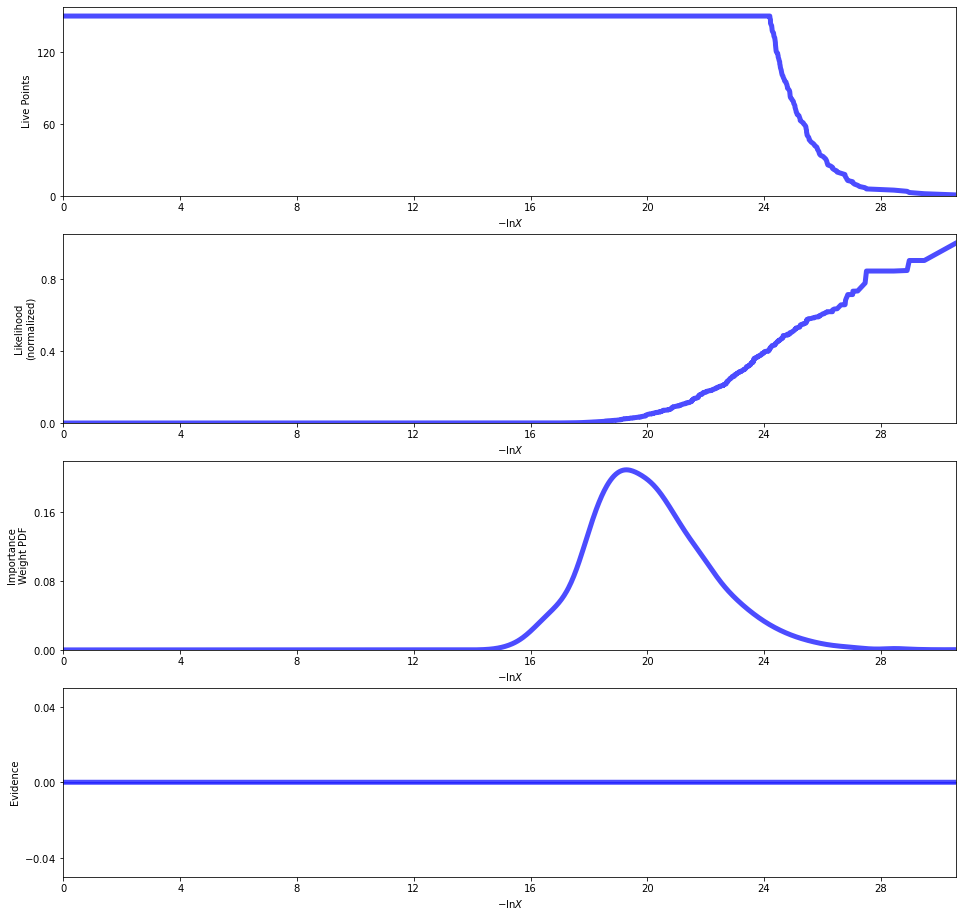

In [108]:
fig, axes = dyplot.runplot(dyfunc.simulate_run(sample_load.results))

In [109]:
# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sample_load.results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean, cov

(array([ 5.36105155,  0.39240761,  0.96882783,  0.46265497, -0.2357708 ,
         7.35765197]),
 array([[ 4.59907271e-04,  1.01028740e-03,  1.01264837e-05,
          7.70292045e-06, -1.47530670e-04, -6.96968619e-04],
        [ 1.01028740e-03,  1.96843632e-01,  6.71081053e-03,
         -1.24032581e-04, -1.08586467e-03,  2.62542947e-04],
        [ 1.01264837e-05,  6.71081053e-03,  2.03073353e-03,
          1.00130304e-05,  1.78519902e-05, -7.77014122e-04],
        [ 7.70292045e-06, -1.24032581e-04,  1.00130304e-05,
          3.12475195e-05,  3.95361740e-06, -1.91180523e-04],
        [-1.47530670e-04, -1.08586467e-03,  1.78519902e-05,
          3.95361740e-06,  4.48201401e-04, -3.01620222e-04],
        [-6.96968619e-04,  2.62542947e-04, -7.77014122e-04,
         -1.91180523e-04, -3.01620222e-04,  6.74917820e-02]]))

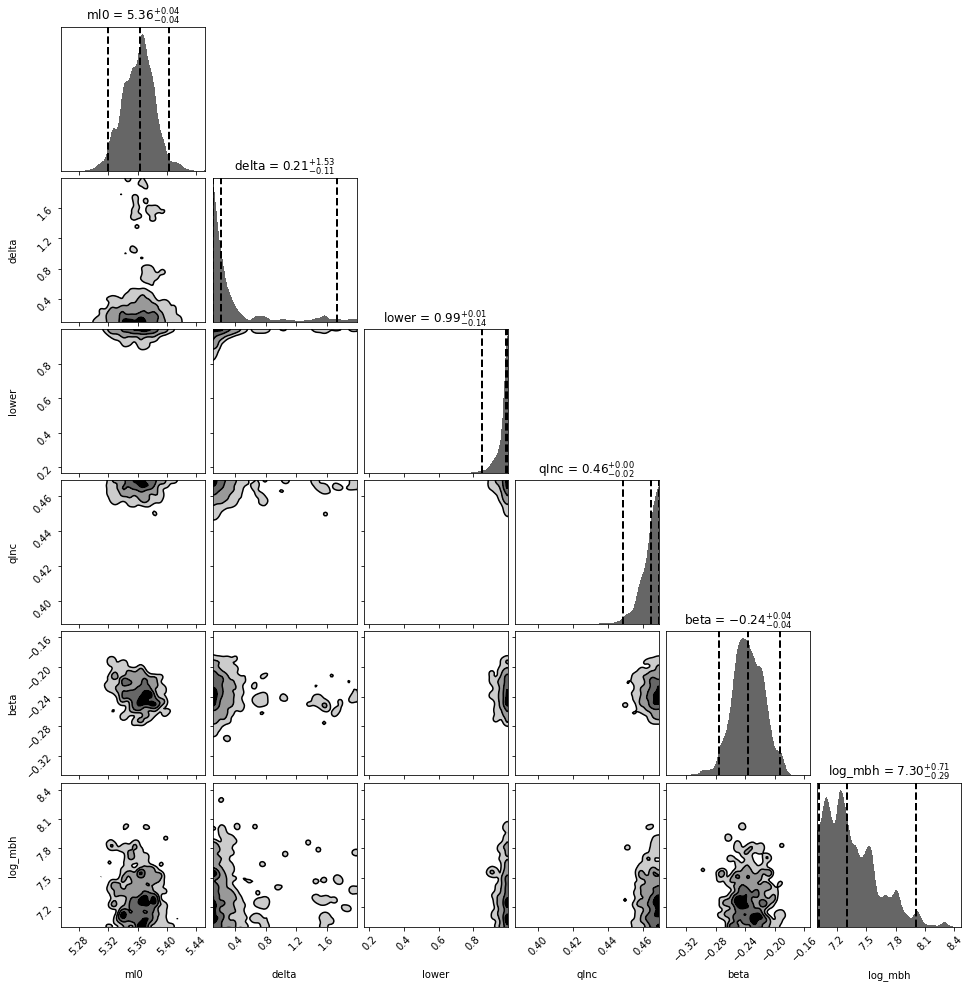

In [110]:
labels = ["ml0", "delta", "lower", "qInc", "beta", "log_mbh"]
cfig, caxes = dyplot.cornerplot(results_sim,show_titles=True,labels=labels,
                               )

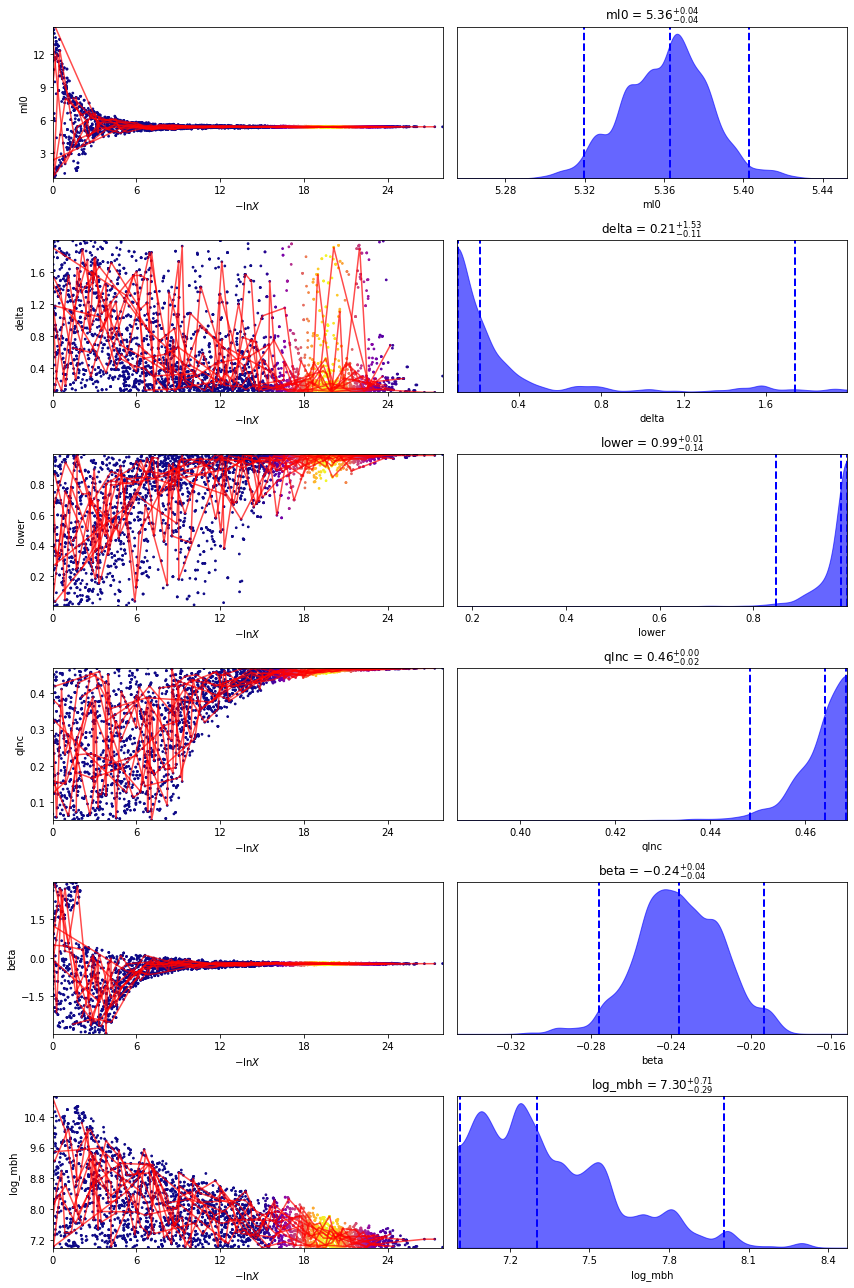

In [111]:
labels = ["ml0", "delta", "lower", "qInc", "beta", "log_mbh"]
rfig, raxes = dyplot.traceplot(results_sim, labels=labels,
                               show_titles=True, connect=True,)
plt.tight_layout()

jam_axi_rms elapsed time sec: 0.22
inc=85.1 beta_z=-0.24 M/L=1 BH=2.28e+07 chi2/DOF=6.63
Total mass MGE: 4.54e+11


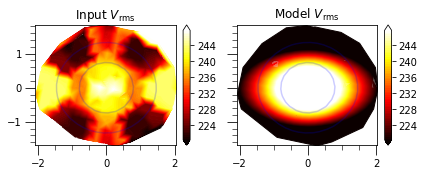

In [112]:
model(mean)
plt.tight_layout()

jam_axi_rms elapsed time sec: 0.22
inc=85.1 beta_z=-0.24 M/L=1 BH=2.28e+07 chi2/DOF=6.63
Total mass MGE: 4.54e+11


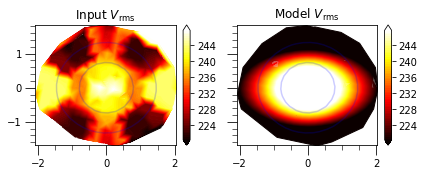

In [113]:
vrmsModel, a, b, c = Jam_model.run(plot=True, quiet=False)
plt.tight_layout()

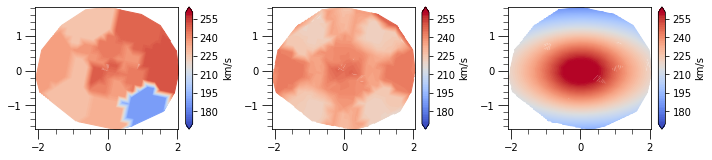

In [114]:
from plotbin.symmetrize_velfield import symmetrize_velfield

sym = symmetrize_velfield(xbin=x,ybin=y,vel_bin=vrms,sym=2)


plt.figure(figsize=(10,8))
plt.subplot(131)
plot_velfield(x=x*pixsize, y=y*pixsize, vel=vrms, colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)

plt.subplot(132)
plot_velfield(x=x*pixsize, y=y*pixsize, vel=sym, colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)

plt.subplot(133)

plot_velfield(x=x*pixsize, y=y*pixsize, vel=vrmsModel,colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)


plt.tight_layout()

In [115]:
with open(f'final_jam_gaussianML_noDM.pickle','rb') as f:
    sample_load = pickle.load(f)

In [117]:
from multiprocessing import Pool
sample_load.pool  = Pool()
sample_load.M     = Pool().map
sample_load.rstate = np.random
sample_load.loglikelihood = model.log_likelihood

jam_axi_rms elapsed time sec: 0.27jam_axi_rms elapsed time sec: 0.27

inc=88.0 beta_z=-0.23 M/L=1 BH=2.10e+07 chi2/DOF=6.61inc=87.2 beta_z=-0.23 M/L=1 BH=2.70e+07 chi2/DOF=6.61


In [ ]:
sample_load.run_nested(dlogz=1e-5)

0it [00:00, ?it/s]

In [119]:
sample_load.results.summary()

Summary
nlive: 150
niter: 3453
ncall: 15438
eff(%): 23.339
logz: -977.712 +/-  0.488
